In [ ]:
import time
from functools import partial

import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mnist

In [4]:
!ls ~/Projects/data/mnist/

Makefile        README.md       test_labels     training_labels
mnist.pkl       test_images     training_images


In [6]:
train_images, train_labels, test_images, test_labels = map(
        mx.array, getattr(mnist, "mnist")()
    )

save_file: /Users/ireriarreola/Projects/data/mnist/mnist.pkl
load pickle from /Users/ireriarreola/Projects/data/mnist/mnist.pkl


In [8]:
train_images.shape

(60000, 784)

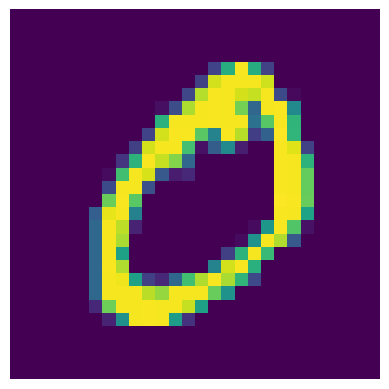

In [119]:
mlx_img = train_images[1,:].reshape(28,28)
np_img = np.array(mlx_img)
plt.imshow(np_img)
plt.axis('off')
plt.show()

In [22]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint32)

In [98]:
class MLP(nn.Module):
    """A simple MLP."""

    def __init__(
        self, num_layers: int, input_dim: int, hidden_dim: int, output_dim: int
    ):
        super().__init__()
        # [784, 32, 32, 10]
        layer_sizes = [input_dim] + [hidden_dim] * num_layers + [output_dim]
        # zip -> [(784, 32), (32, 32), (32, 10)]
        # idim = input dimensions
        # odim = output dimensions
        self.layers = [
            nn.Linear(idim, odim)
            for idim, odim in zip(layer_sizes[:-1], layer_sizes[1:])
        ]
        self.layer_sizes = layer_sizes

    def __call__(self, x):
        for l in self.layers[:-1]:
            # relu(x) = max(x, 0)
            x = nn.relu(l(x))
        return self.layers[-1](x)


def loss_fn(model, X, y):
    return nn.losses.cross_entropy(model(X), y, reduction="mean")


def batch_iterate(batch_size, X, y):
    perm = mx.array(np.random.permutation(y.size))
    for s in range(0, y.size, batch_size):
        ids = perm[s : s + batch_size]
        yield X[ids], y[ids]

seed = 0
num_layers = 2
hidden_dim = 32
num_classes = 10
batch_size = 256
num_epochs = 10
learning_rate = 1e-1

np.random.seed(seed)

In [138]:
mx.array(np.random.permutation(10))

array([5, 3, 7, ..., 8, 0, 4], dtype=int64)

In [141]:
for x in range(0, 100, 10):
    print(x, x+9)

0 9
10 19
20 29
30 39
40 49
50 59
60 69
70 79
80 89
90 99


In [46]:
train_images.shape

(60000, 784)

In [45]:
num_layers, train_images.shape[-1], hidden_dim, num_classes

(2, 784, 32, 10)

In [146]:
model = MLP(num_layers, train_images.shape[-1], hidden_dim, num_classes)
mx.eval(model.parameters())

optimizer = optim.SGD(learning_rate=learning_rate)
loss_and_grad_fn = nn.value_and_grad(model, loss_fn)

train_accuracies = []
test_accuracies = []

@partial(mx.compile, inputs=model.state, outputs=model.state)
def step(X, y):
    loss, grads = loss_and_grad_fn(model, X, y)
    optimizer.update(model, grads)
    return loss

@partial(mx.compile, inputs=model.state)
def eval_fn(X, y):
    return mx.mean(mx.argmax(model(X), axis=1) == y)

# num_epochs = 10
for e in range(num_epochs):
    tic = time.perf_counter()
    # batch_size = 256
    for X, y in batch_iterate(batch_size, train_images, train_labels):
        step(X, y)
        mx.eval(model.state)

    train_accuracy = eval_fn(train_images, train_labels)
    train_accuracies.append(train_accuracy.item())

    accuracy = eval_fn(test_images, test_labels)
    toc = time.perf_counter()
    
    test_accuracies.append(accuracy.item())
    
    print(
        f"Epoch {e}: Test accuracy {accuracy.item():.3f},"
        f" Time {toc - tic:.3f} (s)"
    )

Epoch 0: Test accuracy 0.842, Time 0.245 (s)
Epoch 1: Test accuracy 0.876, Time 0.237 (s)
Epoch 2: Test accuracy 0.921, Time 0.198 (s)
Epoch 3: Test accuracy 0.924, Time 0.240 (s)
Epoch 4: Test accuracy 0.927, Time 0.301 (s)
Epoch 5: Test accuracy 0.938, Time 0.340 (s)
Epoch 6: Test accuracy 0.940, Time 0.364 (s)
Epoch 7: Test accuracy 0.947, Time 0.294 (s)
Epoch 8: Test accuracy 0.950, Time 0.376 (s)
Epoch 9: Test accuracy 0.954, Time 0.455 (s)


In [68]:
model.layer_sizes

[784, 32, 32, 10]

In [70]:
list(zip(model.layer_sizes[:-1], model.layer_sizes[1:]))

[(784, 32), (32, 32), (32, 10)]

In [93]:
w, b = nn.Linear(100, 100).items()
w

('weight',
 array([[0.0040317, 0.0677212, -0.0218915, ..., -0.0177035, -0.0774715, 0.0810578],
        [0.0358371, -0.0606839, -0.0456725, ..., -0.0758067, -0.0266498, 0.0612022],
        [0.0128565, 0.0716553, 0.0247869, ..., -0.0838521, 0.025385, 0.0280653],
        ...,
        [0.00132719, 0.0105682, -0.0104325, ..., 0.0955177, -0.0342532, 0.0362648],
        [0.0863842, 0.095629, -0.0175843, ..., -0.0897395, 0.0235905, -0.0730311],
        [-0.0885102, -0.0950365, 0.0577709, ..., -0.0253269, 0.0285157, -0.0660809]], dtype=float32))

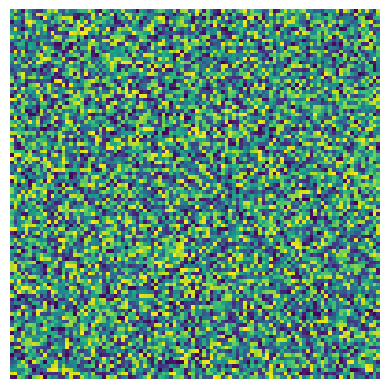

In [96]:
plt.imshow(np.array(w[1]))
plt.axis('off')
plt.show()

<Axes: >

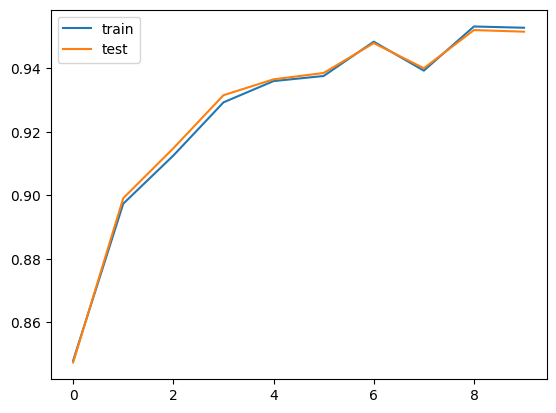

In [62]:
sns.lineplot(train_accuracies, label="train")
sns.lineplot(test_accuracies, label="test")

In [64]:
print(model)

MLP(
  (layers.0): Linear(input_dims=784, output_dims=32, bias=True)
  (layers.1): Linear(input_dims=32, output_dims=32, bias=True)
  (layers.2): Linear(input_dims=32, output_dims=10, bias=True)
)


In [102]:
model(train_images[0,:])

array([2.19932, 1.28882, -1.27215, ..., 0.314991, -1.06754, -0.926146], dtype=float32)

In [110]:
nn.losses.cross_entropy(model(train_images[0,:]), train_labels[0]).item()

0.03025054931640625

In [118]:
model(train_images[1,:]).tolist()

[13.117807388305664,
 -9.949710845947266,
 2.5383663177490234,
 0.529938817024231,
 -8.461225509643555,
 3.035489559173584,
 -0.6043164730072021,
 -0.4339536130428314,
 -0.2572488784790039,
 1.4295778274536133]

In [123]:
nn.losses.cross_entropy(model(train_images[1,:]), mx.zeros(10))

array(13.1179, dtype=float32)

In [135]:
nn.losses.cross_entropy(model(train_images[1,:]), mx.concatenate([mx.ones(1), mx.zeros(9)])).item()

8.296966552734375e-05

In [136]:
nn.losses.cross_entropy(model(train_images[1,:]), mx.concatenate([mx.zeros(9), mx.ones(1)])).item()

11.688312530517578